In [6]:
# import modules
import warnings
warnings.filterwarnings('ignore')

import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, log_loss, f1_score

import random
from math import floor
from scipy.stats import mode, scoreatpercentile

print("Seaborn version : ", sns.__version__)
sns.set()
#sns.set_style('whitegrid')
sns.set_color_codes()
sns.set_theme(style="ticks", palette="pastel")

Seaborn version :  0.11.1


# 신용카드 사용자 연체 예측 AI 경진대회

- 주제: 신용카드 사용자 데이터를 보고 사용자의 대금 연체 정도를 예측하는 알고리즘 개발 
- 목적: 신용카드 사용자들의 개인 신상정보 데이터로 **사용자의 신용카드 대금 연체 정도를 예측**

- 데이터 설명:
    - **gender :** 고객의 성별, **binary**
    - **car :** 고객의 자차 보유 유무, **binary**
    - **reality :** 고객의 부동산 보유 유무, **binary**
    - **child_num :** 고객의 자녀 수, **integer**
    - **income_total :** 고객의 총 소득, **numeric**
    - **income_type :** 고객의 소득 유형, **category**
    - **edu_type :** 고객의 최종 학력, **category**
    - **family_type :** 고객의 본인의 혼인관련 상태, **category**
    - **house_type :** 고객의 거주지 형태, **category**
    - **DAYS_BIRTH :** (고객의 생일) - (현재 일), **integer**, **numeric**
    - **DAYS_EMPLOYED :** (고객의 첫 고용일) - (현재 일), **numeric**
    - **FLAG_MOBIL :** 고객의 본인 휴대폰 전화번호 등록 여부, **binary**
    - **work_phone :** 고객의 본인 직장 전화번호 등록 여부, **binary**
    - **phone :** 고객의 집 전화번호 등록 여부, **binary**
    - **email :** 고객의 이메일 등록여부, **binary**
    - **occyp_type :** 고객의 고용 형태, **category**
    - **family_size :** 고객의 가족의 크기, **integer**, **numeric**
    - **begin_month :** (고객이 카드를 발급한 월) - (현재 월), **integer**, **numeric**  
    
    - **<u>credit</u>** : 해당 신용카드의 대금 연체 정도 (0,1,2 : 커질수록 대금 연체 정도가 높다. target variable)
    
    
## 학습 목표에 대한 논의
### 학습 목표
- ```Credit``` 변수의 클래스 예측.
    - **classes :** 0, 1, 2
    - **description :** 사용자의 신용카드 대금 연체 정도.  
    - 각 값은 **상대적인 크기**에 대한 정보를 가지고 있다.
    - **imbalaced data**

- 다양한 features가 존재하지만 대부분의 feature에서 class의 비율은 일정하다.

- 데이터 관측치의 기준은 **'사용자'**가 아니라 **'카드'**이다. 
    - 카드 정보에만 해당하는 begin_month를 제외하고 모든 값이 일치하는 관측치는 같은 고객이라고 판단한다.
    - 가설) 카드 사용자를 몇 가지 유형으로 분류 할 수 있고, 유형에 따라 begin_month에 해당하는 credit 값들의 기준이 다르다.
    
- 평가기준:
    - **logloss** : 작을수록 좋은 결과


In [2]:
# upload data
train = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/train.csv',
                   index_col=0)
test = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/test.csv',
                  index_col=0)
submit = pd.read_csv('/Users/gangtaro/competition_data/DACON/14thMonthlyDacon/open/sample_submission.csv')

In [5]:
# shape of data
print(train.shape)
print(test.shape)

(26457, 19)
(10000, 18)
(10000, 4)


- 데이터는 총 26457개의 관측치와 총 18개의 feature 그리고 target variable로 이루어져있다.
- public score는 test data의 credit variable 을 예측하는 것으로 총 10000개의 데이터를 예측해야한다.

- table
    1. EDA
    2. Preprocessing
    3. modeling
    
---
## EDA
### target variable
- credit

In [29]:
train.credit.value_counts()

2.0    16968
1.0     6267
0.0     3222
Name: credit, dtype: int64

In [30]:
train.credit.value_counts(normalize = True)

2.0    0.641343
1.0    0.236875
0.0    0.121783
Name: credit, dtype: float64

- 전체 train data set 에서 target variable의 class ratio는 약 2:1:0 = **0.64 : 0.23 : 0.12**이다. 클래스 간 불균형이다.

### binary variables
- gender
- car
- reality
- FLAG_MOBIL
- work_phone
- phone
- email

In [54]:
train.FLAG_MOBIL.value_counts()

1    26457
Name: FLAG_MOBIL, dtype: int64

- FLAG_MOBIL의 원소는 결측치 없이 모두 1으로, 변수로써 가치가 없다. -> 제거

In [150]:
print('<binary variables distribution of the train data>\n')
bin_cols = ['gender', 'car', 'reality', 'work_phone', 'phone', 'email']
for cols in bin_cols : 
    print('* Column name : {}'.format(cols))
    print(train[cols].value_counts(),'\n')


<binary variables distribution of the train data>

* Column name : gender
F    17697
M     8760
Name: gender, dtype: int64 

* Column name : car
N    16410
Y    10047
Name: car, dtype: int64 

* Column name : reality
Y    17830
N     8627
Name: reality, dtype: int64 

* Column name : work_phone
0    20511
1     5946
Name: work_phone, dtype: int64 

* Column name : phone
0    18672
1     7785
Name: phone, dtype: int64 

* Column name : email
0    24042
1     2415
Name: email, dtype: int64 



<Figure size 360x720 with 0 Axes>

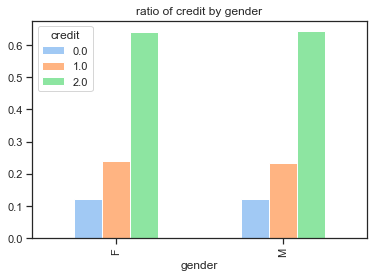

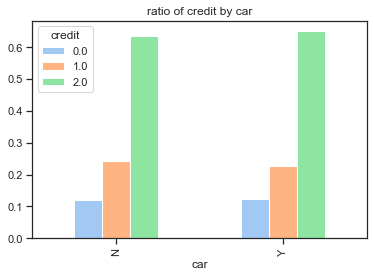

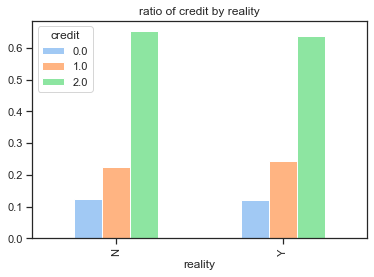

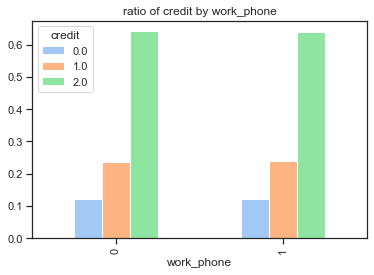

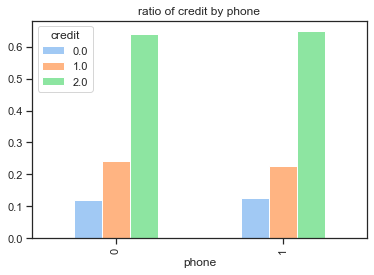

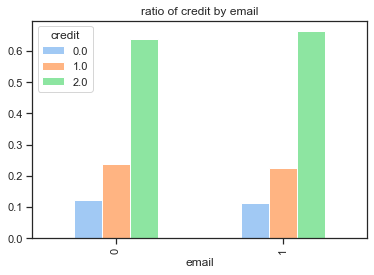

In [112]:
for cols in bin_cols :
    train.groupby(cols).credit.value_counts(normalize = True).unstack().plot(kind = 'bar', title = 'ratio of credit by {}'.format(cols))

- binary columns 에 속하는 'gender', 'car', 'reality', 'work_phone', 'phone', 'email'는 positive와 negative 사이에 credit class간의 비율 차이가 거의 보이지 않는다.


### numeric variables
- child_num
- family_size
- income_total
- DAYS_BIRTH
- DAYS_EMPLOYED
- begin_month

#### child_num
- integer
- 슬하 자녀의 수

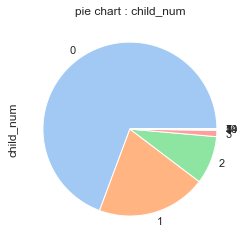

In [203]:
train.child_num.value_counts().sort_index().plot(kind = 'pie')
plt.title('pie chart: child_num')
plt.show()

In [152]:
train.child_num.value_counts().sort_index()

0     18340
1      5386
2      2362
3       306
4        47
5        10
7         2
14        3
19        1
Name: child_num, dtype: int64

- 대부분의 값이 0, 1, 2, 3에 속한다.
- 극히 일부 값들이 7, 14, 19와 같은 값을 지닌다. -> 이상치로 판단하여 train data에서 제거해주도록 한다.

#### family_size
- integer
- 본인 및 배우자, 자녀의 수를 합한 변수 또는 현 거주지에 같이 살고있는 가족의 수라고 추정.(본 관측치의 사람들은 모두 성인으로, 가족에 부모님의 수는 고려하지 않는 것으로 추정된다.)

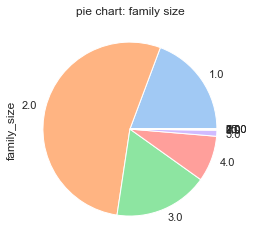

In [209]:
train.family_size.value_counts().sort_index().plot(kind = 'pie')
plt.title('pie chart: family size')
plt.show()

In [207]:
train.family_size.value_counts().sort_index()

1.0      5109
2.0     14106
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
9.0         2
15.0        3
20.0        1
Name: family_size, dtype: int64

- family_type 변수와의 관계를 통해 family_size가 결정된다. (나중에 family_type 변수 설명시에 논한다.)


#### income_total
- numeric, seems like positive-float
- 카드 사용자의 총 소득

In [210]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26457 entries, 0 to 26456
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   gender           26457 non-null  object 
 1   car              26457 non-null  object 
 2   reality          26457 non-null  object 
 3   child_num        26457 non-null  int64  
 4   income_total     26457 non-null  float64
 5   income_type      26457 non-null  object 
 6   edu_type         26457 non-null  object 
 7   family_type      26457 non-null  object 
 8   house_type       26457 non-null  object 
 9   DAYS_BIRTH       26457 non-null  int64  
 10  DAYS_EMPLOYED    26457 non-null  int64  
 11  FLAG_MOBIL       26457 non-null  int64  
 12  work_phone       26457 non-null  int64  
 13  phone            26457 non-null  int64  
 14  email            26457 non-null  int64  
 15  occyp_type       18286 non-null  object 
 16  family_size      26457 non-null  float64
 17  begin_month 

In [161]:
for f_type in train.family_type.unique() : 
    print('*',f_type)
    print((train.family_size - train.child_num).loc[train.family_type == f_type].value_counts())
    print()
    

* Married
 2.0    18193
 0.0        2
-1.0        1
dtype: int64

* Civil marriage
2.0    2122
0.0       1
dtype: int64

* Separated
1.0    1539
dtype: int64

* Single / not married
1.0    3478
2.0      16
0.0       2
dtype: int64

* Widow
1.0    1103
dtype: int64



- family_size - child_num = (본인+배우자 유무)라는 공식이 성립하는 것으로 보인다.
- 하지만 성립하지 않은 데이터가 존재한다.
    - Married 에서 0에 2개의 관측치, -1에 1개의 관측치
    - Civil marriage에서 0에 1개의 관측치
    - Single / not married 에서 2에 16개 관측치, 0에 2개 관측치
    
- 성립하지 않은 데이터에 대해서 확인해보는 것이 필요하다.

In [192]:
train['_age'] = train.DAYS_BIRTH.transform(lambda x : -x/365.25)

train['exp_num'] = 0
train['exp_num'].loc[train.family_type == 'Married'] = 2
train['exp_num'].loc[train.family_type == 'Civil marriage'] = 2
train['exp_num'].loc[train.family_type == 'Separated'] = 1
train['exp_num'].loc[train.family_type == 'Single / not married'] = 1
train['exp_num'].loc[train.family_type == 'Widow'] = 1

train['odd_family_size'] = 0
train['odd_family_size'].loc[(train.family_size - train.child_num) != train.exp_num] = 1

In [205]:
train[['gender','_age', 'child_num', 'family_type', 'family_size', 'occyp_type', 'credit']][train['odd_family_size'] == 1].sort_values('family_type')

,gender,_age,child_num,family_type,family_size,occyp_type,credit
index,,,,,,,
18879,M,34.921287,1,Civil marriage,1.0,NaN,2.0
21096,M,44.966461,1,Married,1.0,Drivers,2.0
16791,F,33.237509,1,Married,1.0,Core staff,2.0
14900,M,40.454483,2,Married,1.0,Drivers,2.0
684,F,48.952772,0,Single / not married,2.0,Cooking staff,2.0
23249,M,48.145106,0,Single / not married,2.0,Drivers,2.0
22776,F,48.142368,0,Single / not married,2.0,Core staff,2.0
22262,F,51.950719,0,Single / not married,2.0,Core staff,2.0
21027,F,42.343600,1,Single / not married,3.0,Low-skill Laborers,2.0


- family_type == 'Married' & 'Civil marriage'
    - family_size == 1인 관측치가 발견된다. 이는 결혼도 했고 자녀도 있으나, 현재 거주지에 혼자 거주하는 것으로 추정한다.
- family_type == 'Single / not married'
    - family_size - child_num == 2, 결혼은 하지 않았으나 동거인이 있다고 추정한다. (사실혼 관계로 추정 -> Married로 변경)
    - family_size - child_num == 0, 자녀가 있지만 자녀와 따로 살고, 현재 거주지에 혼자 거주하는 것으로 추정한다.


- 추가적으로, 여기에 해당하는 데이터는 극히 적은 수이지만, 모든 관측치의 credit의 class가 2로 발견된다.

In [198]:
# 수정된 family_type 추가 : adj_family_type
train['adj_family_type'] = train['family_type']
train['adj_family_type'].loc[(train['family_type'] == 'Single / not married')&(train.family_size - train.child_num == 2)] = 'Married'

In [202]:
# 논외로 family_type == 'Single / not married'에 자녀가 있는 경우도 변수를 추가해준다. => family_type 에서 다시 이야기
sum((train.family_type == 'Single / not married')&(train.child_num != 0))

509

- Single / not married 경우 family_size는 child_num + 1(본인) 로 추정되나 크게 아이가 있는 경우와 아이가 없는 경우가 다르게 나타난다.
- 아이가 있지만 family_size가 1인 경우, 본인의 아이는 있지만 같이 거주하지는 않고, 결혼도 하지 않은 미혼부/미혼녀로 판단할 수 있다.